In [1]:

import sys
import os

sys.path.append('../')
import numpy as np 
import matplotlib.pyplot as plt 
import src_experiment as scf
import geobin as gb 
import pathlib as pl
import torch
from sklearn.datasets import make_moons


training_seed = 42
testing_seed = 41
inference_seed = 40



# Read config file and/or parse cmb-line arguments
# args = scf.get_args()



# # Check if the experiment path exists, if not, create 
# experiment_path = scf.get_path_to_experiment_storage(args.experiment_name)
# state_dict_path = experiment_path/"state_dicts"
# if not state_dict_path.exists():
#     scf.createfolders(state_dict_path)

# Make the data
train_data = scf.make_moon_dataloader(n_samples=10000, noise=0.2, random_state=training_seed, batch_size=250)
test_data = scf.make_moon_dataloader(n_samples=2000, noise=0.2, random_state=testing_seed, batch_size=250)


# # Set up the model based on the parsed arguments or the config file
model = scf.NeuralNet(input_size=2, hidden_sizes=[3,3,3], num_classes=1)

experiment_path = scf.get_path_to_experiment_storage("testing")
state_dict_path = experiment_path/"state_dicts"
if not state_dict_path.exists():
    scf.createfolders(state_dict_path)
    
    
train_metrics, convergence_metrics, state_dicts = scf.train_model(model, train_data, test_data, 250, SAVE_STATES=False, save_everyth_epoch=10, RETURN_STATES=True)

Training: 100%|██████████| 250/250 [00:29<00:00,  8.52it/s]

Training did not converge or was not accurate; states not saved.
Final validation accuracy: 0.885/0.75
 - Validation loss remains high.


In [2]:
state_dicts

{0: OrderedDict([('l1.weight',
               tensor([[ 0.4504, -0.1105],
                       [-0.1244,  0.6668],
                       [ 0.5992, -0.0728]])),
              ('l1.bias', tensor([-0.0689,  0.4727,  0.5263])),
              ('l2.weight',
               tensor([[ 0.3890,  0.5331, -0.2939],
                       [ 0.4207, -0.2427, -0.3255],
                       [-0.0679, -0.4154, -0.4127]])),
              ('l2.bias', tensor([-0.0681,  0.3708,  0.2884])),
              ('l3.weight',
               tensor([[-0.5288,  0.5516,  0.1052],
                       [ 0.1816,  0.2756, -0.5057],
                       [-0.5199,  0.0275,  0.4505]])),
              ('l3.bias', tensor([ 0.2898,  0.1397, -0.3301])),
              ('l4.weight', tensor([[ 0.3872, -0.4489,  0.4374]])),
              ('l4.bias', tensor([-0.3061]))]),
 10: OrderedDict([('l1.weight',
               tensor([[ 0.5188, -0.1171],
                       [-0.2492,  0.7844],
                       [ 0.5741, -0.0

In [3]:
train_metrics

{'train_loss': array([0.68757051, 0.67980625, 0.67207095, 0.66418469, 0.65590106,
        0.64696669, 0.63710828, 0.62608129, 0.61361565, 0.59945686,
        0.58347876, 0.56564476, 0.54607149, 0.52500997, 0.50287698,
        0.48022521, 0.45764496, 0.43564855, 0.4148017 , 0.39562659,
        0.37854613, 0.3637248 , 0.35115739, 0.34066495, 0.33196822,
        0.32476866, 0.31880285, 0.31385368, 0.30971315, 0.30625811,
        0.30336268, 0.30093055, 0.29888951, 0.29717526, 0.29573223,
        0.29449869, 0.29345961, 0.29254849, 0.29175352, 0.29103897,
        0.29039666, 0.2898143 , 0.28927604, 0.28878042, 0.28830762,
        0.28787456, 0.28745577, 0.28706388, 0.28669049, 0.28633916,
        0.28600101, 0.28567128, 0.28535288, 0.28504141, 0.28473399,
        0.28442889, 0.28412892, 0.28383247, 0.28353898, 0.2832451 ,
        0.28294729, 0.28264892, 0.28235308, 0.28205883, 0.28176651,
        0.28147514, 0.28118409, 0.28089333, 0.28060244, 0.28031136,
        0.28001977, 0.27972854, 0.

In [4]:
convergence_metrics

{'converged': True,
 'stability': np.True_,
 'loss_plateau': np.True_,
 'acc_plateau': np.True_,
 'overfitting': np.False_,
 'local_minimum': True,
 'accurate': np.True_,
 'globalish_minimum': False,
 'min_acceptable_acc': 0.75,
 'reasons': ['Validation loss remains high.'],
 'saved': False}

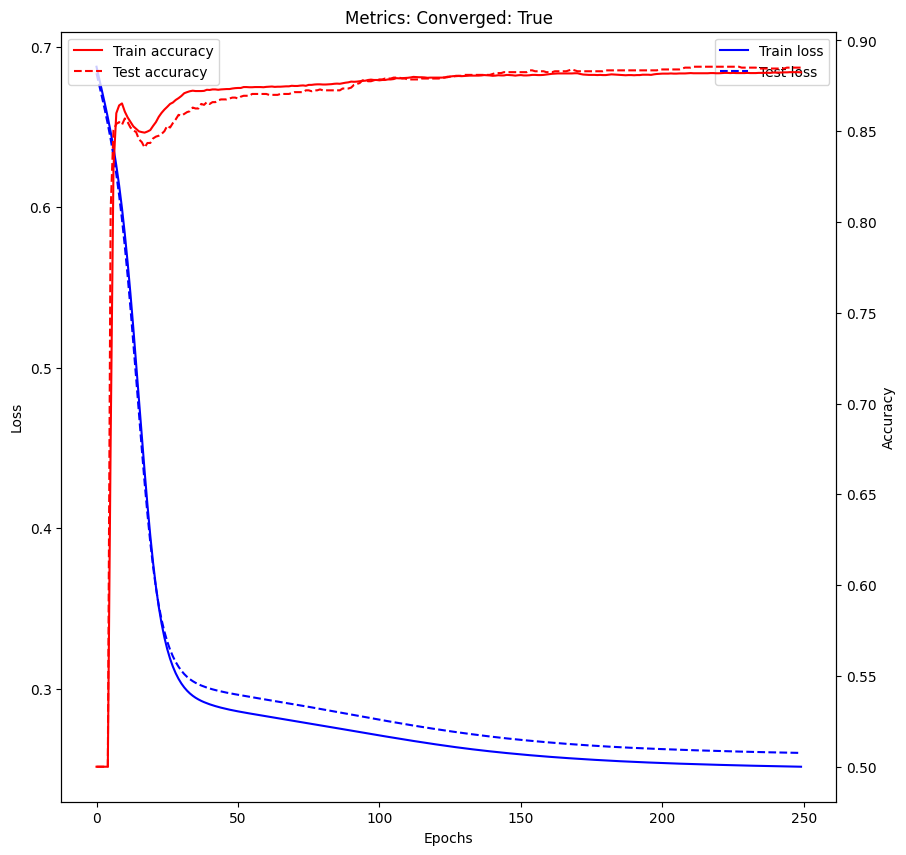

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(train_metrics["train_loss"], color="blue", label="Train loss")
ax.plot(train_metrics["test_loss"], color="blue", ls="dashed", label="Test loss")

ax2 = ax.twinx()
ax2.plot(train_metrics["train_accuracy"], color="red", label="Train accuracy")
ax2.plot(train_metrics["test_accuracy"], color="red", ls="dashed", label="Test accuracy")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax.set_title(f"Metrics: Converged: {convergence_metrics['converged']}")
ax.legend()
ax2.legend()

In [6]:
inference_data = scf.make_moon_dataloader(n_samples=1000, noise=0.15, random_state=inference_seed, batch_size=250)

In [7]:
import os
lwmi_per_epoch = {}
for epoch, state_dict in state_dicts.items():
    # print(epoch,state_dict)
    # Find epoch
    # epoch = eval(state_dict[13:-4])
    # epoch = eval(epoch)
    # Load state dict
    # state_dict = torch.load(state_dict_path / state_dict)
    
    # Build tree
    tree = gb.RegionTree(state_dict)
    tree.build_tree(verbose=False)
    
    # Pass inference data through tree
    tree.pass_dataloader_through_tree(inference_data)
    # Find the number counts
    tree.collect_number_counts()
    ncounts = tree.get_number_counts()
    
    # Calculate layer-wise mi from number counts
    lwmi = gb.layer_wise_MI_from_number_counts(ncounts)
    
    # Store
    lwmi_per_epoch[epoch] = lwmi
    
    

/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pan

In [8]:
# tree.reset_counters()
# tree.collect_number_counts()
# tree.get_number_counts()

In [9]:
lwmi_per_epoch

{0: {1: 0.1575868708447118,
  2: 0.3719103709936696,
  3: 0.37198215115824235,
  4: 0.37198215115824235},
 10: {1: 0.23604832503009865,
  2: 0.2844930098585612,
  3: 0.35347434737564715,
  4: 0.41198173335539345},
 20: {1: 0.279929602117601,
  2: 0.28008678851523117,
  3: 0.36469752289610313,
  4: 0.3870022602030326},
 30: {1: 0.2756857290982429,
  2: 0.2768820731259957,
  3: 0.35938630873059657,
  4: 0.3901832835973423},
 40: {1: 0.2599868172338171,
  2: 0.2617205278778842,
  3: 0.33058098767203264,
  4: 0.3834681905082447},
 50: {1: 0.25795397809175324,
  2: 0.2601858063525303,
  3: 0.3197944183122626,
  4: 0.385684771802635},
 60: {1: 0.25149465952198996,
  2: 0.25258503238512936,
  3: 0.29587902709441233,
  4: 0.381086237837673},
 70: {1: 0.24453276398799786,
  2: 0.24664735158799755,
  3: 0.27483115862367336,
  4: 0.37191870590910886},
 80: {1: 0.2389597460917992,
  2: 0.23948117470576286,
  3: 0.25669237443059456,
  4: 0.3651603659068412},
 90: {1: 0.21947867850354819,
  2: 0.220

In [10]:
from collections import defaultdict

layer_to_mi = defaultdict(dict)

# Build inverted dictionary
for epoch, layer_dict in lwmi_per_epoch.items():
    for layer, mi in layer_dict.items():
        layer_to_mi[layer][epoch] = mi

# Sort by epoch number
layer_to_mi = {
    layer: dict(sorted(epoch_dict.items(), key=lambda x: x[0]))
    for layer, epoch_dict in layer_to_mi.items()
}

In [11]:
layer_to_mi

{1: {0: 0.1575868708447118,
  10: 0.23604832503009865,
  20: 0.279929602117601,
  30: 0.2756857290982429,
  40: 0.2599868172338171,
  50: 0.25795397809175324,
  60: 0.25149465952198996,
  70: 0.24453276398799786,
  80: 0.2389597460917992,
  90: 0.21947867850354819,
  100: 0.2148454780229394,
  110: 0.20356643875685304,
  120: 0.20177887894659113,
  130: 0.20254055200250154,
  140: 0.2050765611774918,
  150: 0.197348981544288,
  160: 0.19003824144145107,
  170: 0.1877569228364425,
  180: 0.1830057248547311,
  190: 0.18208745374250274,
  200: 0.18282933037889862,
  210: 0.18164653774380482,
  220: 0.18020475018342036,
  230: 0.18021892472528458,
  240: 0.17542117033407081,
  249: 0.1739881259279361},
 2: {0: 0.3719103709936696,
  10: 0.2844930098585612,
  20: 0.28008678851523117,
  30: 0.2768820731259957,
  40: 0.2617205278778842,
  50: 0.2601858063525303,
  60: 0.25258503238512936,
  70: 0.24664735158799755,
  80: 0.23948117470576286,
  90: 0.22053060960443943,
  100: 0.2158981737154348

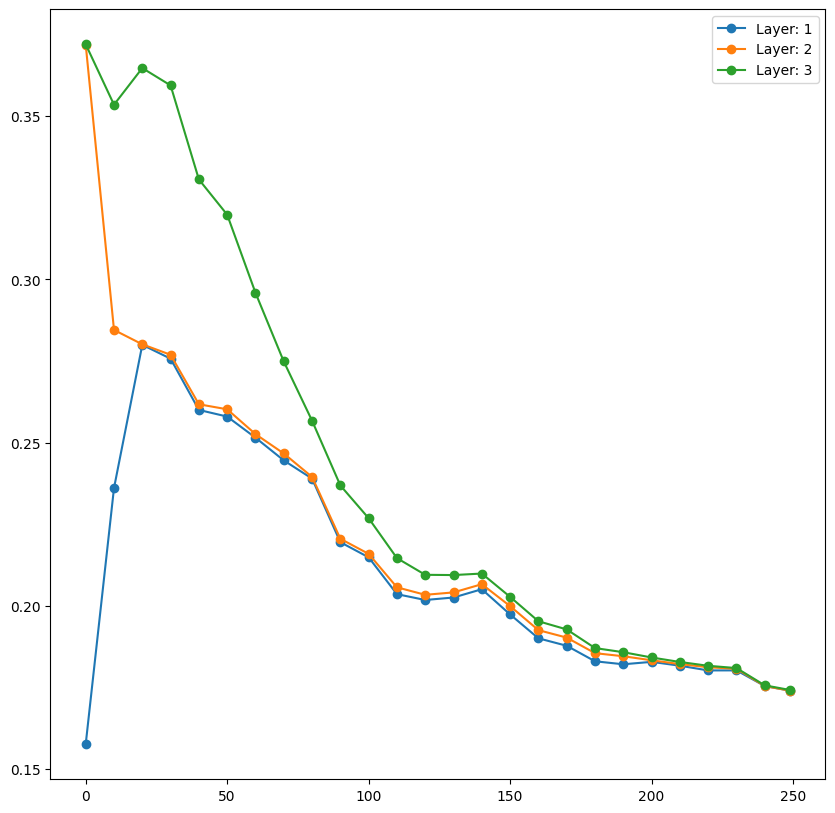

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

# iterate over all layers except the last one
for layer, val in list(layer_to_mi.items())[:-1]:
    ax.plot(val.keys(), val.values(), "o-", label=f"Layer: {layer}")

ax.legend()
plt.show()

In [13]:
scf.get_specific_moon_state_dict(
    model_name="small_uniform",
    dataset_name="small",
    noise_level=0.2,
    run_number=1,
    epoch=10
)



OrderedDict([('l1.weight',
              tensor([[ 1.1241, -0.8699],
                      [ 1.3479, -0.4570],
                      [-0.2126,  0.3717]])),
             ('l1.bias', tensor([1.2451, 0.3616, 0.5098])),
             ('l2.weight',
              tensor([[ 1.5496, -0.9423,  0.0870],
                      [ 0.1191,  0.4126, -0.1861],
                      [-0.7846,  1.0242,  0.8669]])),
             ('l2.bias', tensor([0.0906, 0.8969, 0.8678])),
             ('l3.weight',
              tensor([[-0.6411,  0.6921,  1.2645],
                      [ 1.2811,  0.2188, -0.7084],
                      [ 0.9248,  0.4848, -0.5390]])),
             ('l3.bias', tensor([1.0621, 0.6649, 0.3108])),
             ('l4.weight', tensor([[-1.8316,  1.4608,  1.1252]])),
             ('l4.bias', tensor([-1.4782]))])

In [14]:
# Test saving tree as pickle object

# 1 Try to use cpickle for faster saving/loading, otherwise use pickle
try:
    import cpickle as pickle
except ModuleNotFoundError:
    import pickle
    
# 2 Define output path
print(scf.paths.current_dir)
    

    
    # tree = gb.RegionTree(state_dict)
    # tree.build_tree(verbose=False)
    
    # # Pass inference data through tree
    # tree.pass_dataloader_through_tree(inference_data)
    # # Find the number counts
    # tree.collect_number_counts()
    # ncounts = tree.get_number_counts()

scf.paths.get_path_to_moon_experiment_storage(
    model_name="small_uniform",
    dataset_name="small",
    noise_level=0.0,
    run_number=1
)


# Source - https://stackoverflow.com/a
# Posted by martineau, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-05, License - CC BY-SA 4.0

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
def open_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
    return obj



def find_and_store_trees(model_name: str,
                         dataset_name: str,
                         noise_level: float,
                         run_number: int,
                         epochs: list[int]):
    savepath = scf.paths.get_path_to_moon_experiment_storage(
        model_name=model_name,
        dataset_name=dataset_name,
        noise_level=noise_level,
        run_number=run_number
    )
    
    trees = {}
    for epoch in epochs:
        state_dict = scf.get_specific_moon_state_dict(
            model_name=model_name,
            dataset_name=dataset_name,
            noise_level=noise_level,
            run_number=run_number,
            epoch=epoch)
        tree = gb.RegionTree(state_dict)
        tree.build_tree(verbose=False)
        trees[epoch] = tree
    # Save trees as pickle object
    
    save_object(trees, savepath/"trees.pkl")

/home/johan/Documents/phd/WP1/geometric_binning_estimator


In [15]:
find_and_store_trees(
    model_name="small_uniform",
    dataset_name="small",
    noise_level=0.0,
    run_number=1,
    epochs=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,249]
)

In [16]:
# Load the trees back
savepath = scf.paths.get_path_to_moon_experiment_storage(
    model_name="small_uniform",
    dataset_name="small",
    noise_level=0.0,
    run_number=1,
)
trees = open_object(savepath/"trees.pkl")



In [17]:
trees

{0: <geobin.region_tree.RegionTree at 0x7de40d68ec10>,
 10: <geobin.region_tree.RegionTree at 0x7de593c699b0>,
 20: <geobin.region_tree.RegionTree at 0x7de40d795240>,
 30: <geobin.region_tree.RegionTree at 0x7de593df78c0>,
 40: <geobin.region_tree.RegionTree at 0x7de593df7e00>,
 50: <geobin.region_tree.RegionTree at 0x7de40d68c670>,
 60: <geobin.region_tree.RegionTree at 0x7de40d68e2e0>,
 70: <geobin.region_tree.RegionTree at 0x7de40d68d7f0>,
 80: <geobin.region_tree.RegionTree at 0x7de40d68d710>,
 90: <geobin.region_tree.RegionTree at 0x7de40d68d9b0>,
 100: <geobin.region_tree.RegionTree at 0x7de40d68d860>,
 110: <geobin.region_tree.RegionTree at 0x7de40d68da20>,
 120: <geobin.region_tree.RegionTree at 0x7de40d68da90>,
 130: <geobin.region_tree.RegionTree at 0x7de40d68db70>,
 140: <geobin.region_tree.RegionTree at 0x7de40d68dbe0>,
 150: <geobin.region_tree.RegionTree at 0x7de40d68dd30>,
 160: <geobin.region_tree.RegionTree at 0x7de40d68dda0>,
 170: <geobin.region_tree.RegionTree at 0x

In [42]:
lwmi_per_epoch = {}
number_counts_per_epoch = {}
for epoch, tree in trees.items():
    # print(epoch,state_dict)
    # Find epoch
    # epoch = eval(state_dict[13:-4])
    # epoch = eval(epoch)
    # Load state dict
    # state_dict = torch.load(state_dict_path / state_dict)
    
    # Build tree
    
    # Pass inference data through tree
    tree.pass_dataloader_through_tree(inference_data)
    # Find the number counts
    tree.collect_number_counts()
    ncounts = tree.get_number_counts()
    number_counts_per_epoch[epoch] = ncounts
    # print(ncounts)
    
    # # Calculate layer-wise mi from number counts
    # lwmi = gb.layer_wise_MI_from_number_counts(ncounts)
    
    # # Store
    # lwmi_per_epoch[epoch] = lwmi

save_object(number_counts_per_epoch, savepath/"number_counts_per_epoch.pkl")
# from collections import defaultdict

# lwmi_per_layer = defaultdict(dict)

# # Build inverted dictionary
# for epoch, layer_dict in lwmi_per_epoch.items():
#     for layer, mi in layer_dict.items():
#         lwmi_per_layer[layer][epoch] = mi

# # Sort by epoch number
# lwmi_per_layer = {
#     layer: dict(sorted(epoch_dict.items(), key=lambda x: x[0]))
#     for layer, epoch_dict in lwmi_per_layer.items()
# }

In [44]:
# New logic for computing MI for number counts given stored number counts
number_counts_per_epoch = open_object(savepath/"number_counts_per_epoch.pkl")
lwmi_per_epoch = {}
for epoch, ncounts in number_counts_per_epoch.items():
    # Calculate layer-wise mi from number counts
    lwmi = gb.layer_wise_MI_from_number_counts(ncounts)
    # print(f"Epoch {epoch}: {lwmi}")
    
    # Store
    lwmi_per_epoch[epoch] = lwmi



# NEWlwmi_per_layer = defaultdict(dict)

NEW_lwmi_per_layer = defaultdict(dict)

# Build inverted dictionary
for epoch, layer_dict in lwmi_per_epoch.items():
    for layer, mi in layer_dict.items():
        NEW_lwmi_per_layer[layer][epoch] = mi

# Sort by epoch number
NEW_lwmi_per_layer = {
    layer: dict(sorted(epoch_dict.items(), key=lambda x: x[0]))
    for layer, epoch_dict in NEW_lwmi_per_layer.items()
}

/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pan

In [45]:
number_counts_per_epoch

{0:       layer_idx  region_idx      0      1   total
 202           1           1  927.0   69.0   996.0
 378           2          57  927.0   69.0   996.0
 397           3         441  363.0    0.0   363.0
 398           4         441  363.0    0.0   363.0
 400           3         505  564.0   69.0   633.0
 401           4         505  564.0   69.0   633.0
 805           1           4   36.0  267.0   303.0
 981           2          60   36.0  267.0   303.0
 1003          3         508   36.0  267.0   303.0
 1005          4        1020   36.0  267.0   303.0
 1006          1           5  267.0  300.0   567.0
 1182          2          61  267.0  300.0   567.0
 1204          3         509  267.0  300.0   567.0
 1205          4         509  147.0  141.0   288.0
 1206          4        1021  120.0  159.0   279.0
 1207          1           6  258.0  864.0  1122.0
 1358          2          54    0.0  318.0   318.0
 1368          3         246    0.0  318.0   318.0
 1370          4         758

In [46]:
NEW_lwmi_per_layer

{1: {0: 0.24039182409271043,
  10: 0.2500479560185488,
  20: 0.25518721112652204,
  30: 0.2664954021199103,
  40: 0.2802951007459787,
  50: 0.28248703427682004,
  60: 0.2977631672330411,
  70: 0.32228552762777674,
  80: 0.32945353567545177,
  90: 0.3482687619188227,
  100: 0.3677828044312056,
  110: 0.39450308657717237,
  120: 0.4139074937676243,
  130: 0.43746391201831153,
  140: 0.4689852778417202,
  150: 0.4933024102785208,
  160: 0.5094301351852997,
  170: 0.5208261857930612,
  180: 0.5233272166712858,
  190: 0.5159635368995307,
  200: 0.4964264415796931,
  210: 0.48461841105357645,
  220: 0.4539589026631133,
  230: 0.428753978284499,
  240: 0.4290382454297103,
  249: 0.42508963931721255},
 2: {0: 0.2738755803176601,
  10: 0.30328598469580653,
  20: 0.31269295918378476,
  30: 0.3285733428147874,
  40: 0.33977174029398627,
  50: 0.3485701842015278,
  60: 0.36230007126246144,
  70: 0.38037168942433464,
  80: 0.381427270668808,
  90: 0.39258668603352,
  100: 0.4043257083882977,
  110:

In [20]:
import pandas as pd
frame = pd.DataFrame(lwmi_per_layer)
frame.to_csv(savepath/"layer_wise_mi.csv")

In [21]:
savepath/"layer_wise_mi.csv"

PosixPath('/home/johan/Documents/phd/WP1/geometric_binning_estimator/stored_data/variable_noise_moons_experiment/model_small_uniform/dataset_small/noise_0.0/run_1/layer_wise_mi.csv')

In [22]:
frame

,1,2,3,4
0,0.240392,0.273876,0.309817,0.310430
10,0.250048,0.303286,0.325292,0.326554
20,0.255187,0.312693,0.334324,0.336039
30,0.266495,0.328573,0.347178,0.348375
40,0.280295,0.339772,0.360602,0.362563
50,0.282487,0.348570,0.369202,0.372696
60,0.297763,0.362300,0.379596,0.384654
70,0.322286,0.380372,0.395596,0.404548
80,0.329454,0.381427,0.399786,0.412093
90,0.348269,0.392587,0.413101,0.435371


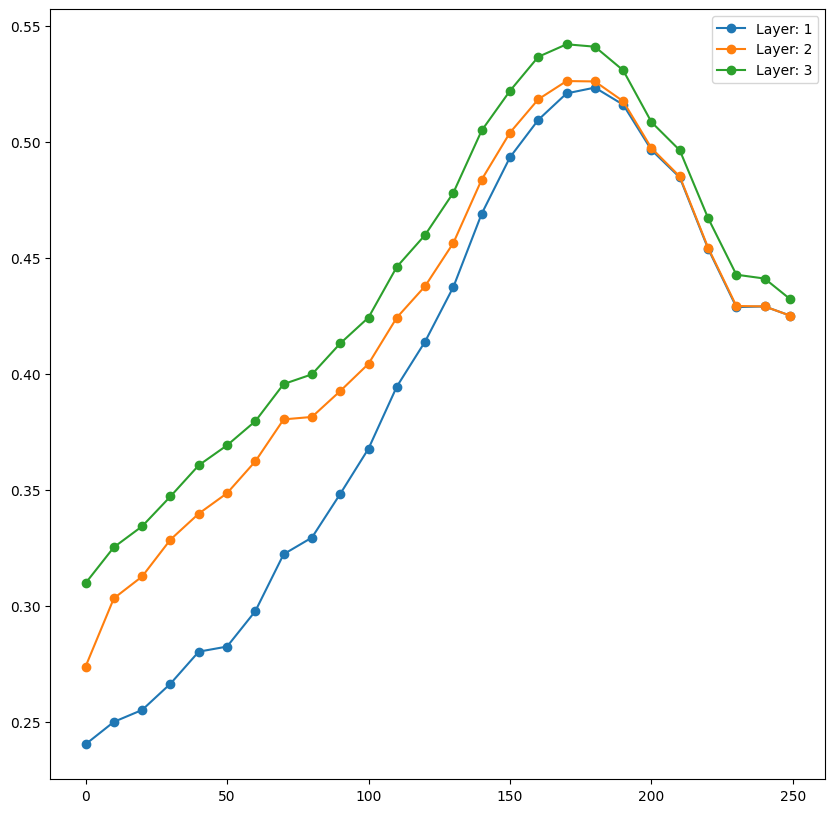

In [47]:
fig, ax = plt.subplots(figsize=(10,10))

# iterate over all layers except the last one
for layer, val in list(NEW_lwmi_per_layer.items())[:-1]:
    ax.plot(val.keys(), val.values(), "o-", label=f"Layer: {layer}")

ax.legend()
plt.show()